In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

#  TODO 

## Hyper parameter share information only with particular timezone
Timezones : Morning(7 to)

# Reading Location Names

In [2]:
aruba_dataset_path = '/data/dataDeebul/thesis/dataset/strands/aruba/locations.names'

location_names = {}
count = 0
with open(aruba_dataset_path, 'r') as content_file:
    content = content_file.read()
    content = str.splitlines(content)
for count,location in enumerate(content):
    location_names[count] = location
print(location_names)


{0: 'Master bedroom', 1: 'Master bathroom', 2: 'Living room', 3: 'Kitchen', 4: 'Center', 5: 'Corridor', 6: 'Second bedroom', 7: 'Office', 8: 'Second bathroom', 9: 'Outside'}


# Reading location data

In [3]:
aruba_dataset_path = '/data/dataDeebul/thesis/dataset/strands/aruba/locations.min'

dataset = pd.read_csv(aruba_dataset_path, names=['location', 'time'])
dataset['time'] = dataset.index
dataset['time'] = pd.to_timedelta(dataset['time'], unit='m')
dataset['day'] = (dataset['time']/ np.timedelta64(1, 'D')).astype(int)
dataset['hour'] = (dataset['time']/ np.timedelta64(1, 'h')).astype(int)
def mod_for_hour(row):
    return row['hour'] % 24
dataset['sep_hour'] = dataset.apply(mod_for_hour, axis=1)


In [4]:
#Renaming location number with their names
for key,value in location_names.items():
    dataset.ix[dataset.location ==key, 'location_name'] = value


# Reducing the dataset

The ARUBA dataset is a well
Since we have 112 days per minute readings (161280 readings). We will create reduced datasets with the
following assumptions 
    - 3 readings every day ( 112 * 3 = 336) 
    - 5 readings everyday (112 * 5 = 560) 
    - 10 readings everyday (112 * 10 = 1120)


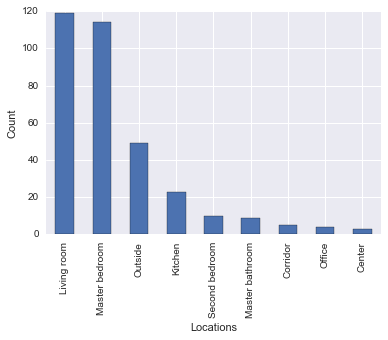

In [5]:
%matplotlib inline
import random
import matplotlib.pyplot as plt
rows = random.sample(list(dataset.index), 336)
reduced_dataset_3readings = dataset.ix[rows]
rows = random.sample(list(dataset.index), 560)
reduced_dataset_5readings = dataset.ix[rows]
rows = random.sample(list(dataset.index), 1120)
reduced_dataset_10readings = dataset.ix[rows]

ax = (reduced_dataset_3readings['location_name'].value_counts()).plot(kind='bar')
ax.set_xlabel("Locations")
ax.set_ylabel("Count")

In [6]:
reduced_dataset_3readings.set_index(np.arange(reduced_dataset_3readings.shape[0]), inplace=True)

# Some Data Analysis

In [7]:
hour_vs_location = pd.crosstab(reduced_dataset_3readings['location'], 
                               reduced_dataset_3readings['sep_hour'])

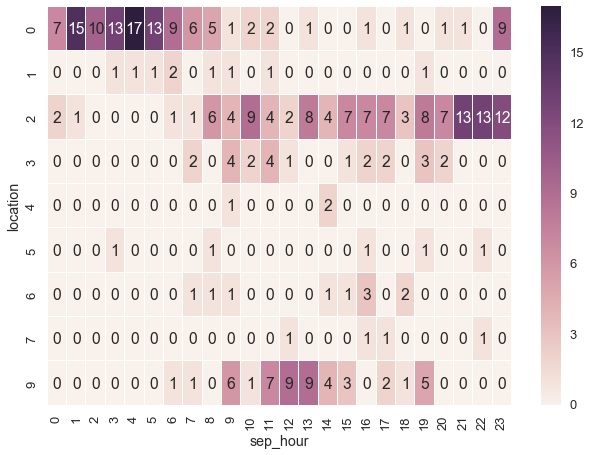

In [8]:
sns.set_context('talk')
sns.set_style('darkgrid')
sns.heatmap(hour_vs_location, linewidths=.01, annot=True)
plt.xticks(rotation=90)
plt.show()


# Model Based Machine Lerning

Creating Hierarchical Model
![Hierarchical Model](images/hierarchicalmodel.png)

In [9]:
#Some constants
n_locations = len(location_names.values())
n_timezones = 24
#n_trials = reduced_dataset_3readings.shape[0]
n_trials = 50

from bayespy import nodes
p_theta = nodes.Dirichlet(np.ones(n_locations)*0.1,
                          plates=(n_timezones,),
                          name='p_theta')

#Taking readings of sep_hour as we know the time in which the reading was taken
#Reshaing it meet th plates
recordings_time = reduced_dataset_3readings.ix[:n_trials-1, 'sep_hour'].as_matrix().reshape((n_trials, 1))

Y = nodes.Mixture(recordings_time, nodes.Categorical, p_theta)

# Observe Data

In [10]:
Y.observe(reduced_dataset_3readings.ix[:n_trials-1, 'location'].reshape((n_trials, 1)))

# Inference

In [11]:
from bayespy.inference import VB
Q = VB(Y, p_theta)
Q.update(repeat=1000)

Iteration 1: loglike=-9.325346e+01 (0.000 seconds)
Iteration 2: loglike=-9.325346e+01 (0.000 seconds)
Converged at iteration 2.


In [12]:
learned_params = np.array(p_theta.get_parameters()).reshape((24,10))

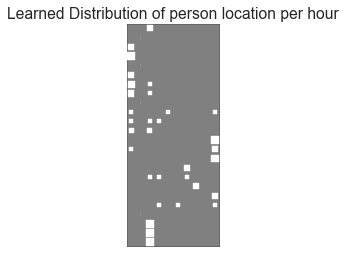

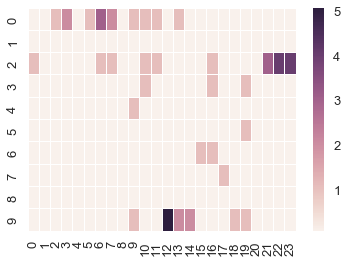

In [13]:
%matplotlib inline
import bayespy.plot as bpplt
bpplt.hinton(p_theta)
bpplt.pyplot.title("Learned Distribution of person location per hour")
bpplt.pyplot.show()

sns.heatmap(learned_params.T, linewidths=.01)


Iteration 1: loglike=-4.733362e+02 (0.010 seconds)
Iteration 2: loglike=-4.429158e+02 (0.020 seconds)
Iteration 3: loglike=-4.298749e+02 (0.010 seconds)
Iteration 4: loglike=-4.231986e+02 (0.020 seconds)
Iteration 5: loglike=-4.191214e+02 (0.000 seconds)
Iteration 6: loglike=-4.162801e+02 (0.010 seconds)
Iteration 7: loglike=-4.141397e+02 (0.010 seconds)
Iteration 8: loglike=-4.124641e+02 (0.010 seconds)
Iteration 9: loglike=-4.111294e+02 (0.010 seconds)
Iteration 10: loglike=-4.100580e+02 (0.010 seconds)
Iteration 11: loglike=-4.091939e+02 (0.010 seconds)
Iteration 12: loglike=-4.084941e+02 (0.010 seconds)
Iteration 13: loglike=-4.079249e+02 (0.010 seconds)
Iteration 14: loglike=-4.074593e+02 (0.000 seconds)
Iteration 15: loglike=-4.070761e+02 (0.010 seconds)
Iteration 16: loglike=-4.067586e+02 (0.010 seconds)
Iteration 17: loglike=-4.064938e+02 (0.010 seconds)
Iteration 18: loglike=-4.062711e+02 (0.000 seconds)
Iteration 19: loglike=-4.060825e+02 (0.010 seconds)
Iteration 20: loglike

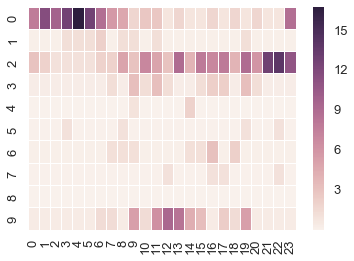

In [16]:
#Some constants
n_locations = len(location_names.values())
n_timezones = 24
#n_trials = reduced_dataset_3readings.shape[0]
n_trials = 300

from bayespy import nodes
p_conc = nodes.DirichletConcentration(n_locations)
p_conc.initialize_from_value(np.ones(n_locations))
p_theta = nodes.Dirichlet(p_conc,
                          plates=(n_timezones,),
                          name='p_theta')
recordings_time = reduced_dataset_3readings.ix[:n_trials-1, 'sep_hour'].as_matrix().reshape((n_trials, 1))

Y = nodes.Mixture(recordings_time, nodes.Categorical, p_theta)

#Observe Data
Y.observe(reduced_dataset_3readings.ix[:n_trials-1, 'location'].reshape((n_trials, 1)))

#Inference
Q = VB(Y, p_theta, p_conc)
Q.update(repeat=1000)

#Evaluation
learned_params = np.array(p_theta.get_parameters()).reshape((24,10))
sns.heatmap(learned_params.T, linewidths=.01)


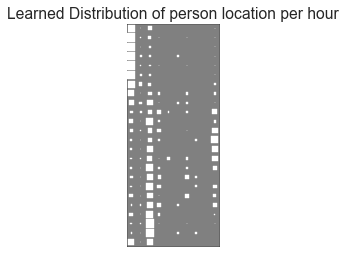

In [17]:
bpplt.hinton(p_theta)
bpplt.pyplot.title("Learned Distribution of person location per hour")
bpplt.pyplot.show()